# 시각화

c:\Users\islab\.conda\envs\mings\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 169001437/169001437 [00:11<00:00, 14085190.38it/s]


Extracting ./data\cifar-100-python.tar.gz to ./data


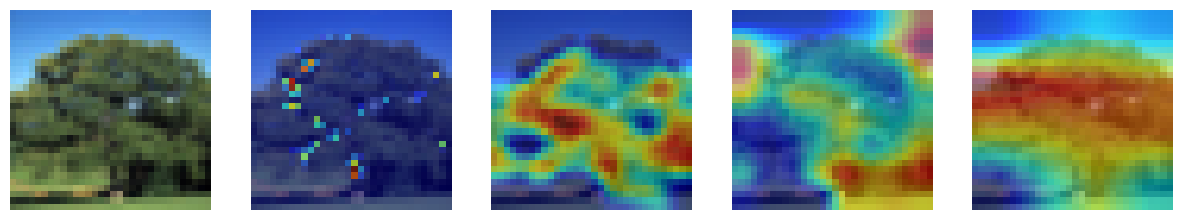

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import pandas as pd
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt 
import sys

class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34

    """
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

# 222222
class L_BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34

    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * L_BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * L_BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != L_BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * L_BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * L_BasicBlock.expansion)
            )

    def forward(self, x):
        x_1 = x.clone().detach()
        x_fft = torch.fft.fft2(x, dim=(2, 3))
        x_fft_shifted = torch.fft.fftshift(x_fft, dim=(2, 3))

        rows, cols = x_fft_shifted.shape[2], x_fft_shifted.shape[3]
        center_row, center_col = rows // 2, cols // 2
        cutoff_frequency = min(rows, cols) // 3

        high_pass_mask = torch.ones_like(x_fft_shifted, dtype=torch.float32)
        low_pass_mask = torch.zeros_like(x_fft_shifted, dtype=torch.float32)
        
        y, x = torch.meshgrid(torch.arange(rows), torch.arange(cols), indexing='ij')
        dist = torch.sqrt((x - center_col)**2 + (y - center_row)**2)

        high_pass_mask[:, :, dist <= cutoff_frequency] = 0
        low_pass_mask[:, :, dist <= cutoff_frequency] = 1

        high_pass = x_fft_shifted * high_pass_mask
        low_pass = x_fft_shifted * low_pass_mask

        high_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(high_pass, dim=(2, 3)), dim=(2, 3)).real
        low_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(low_pass, dim=(2, 3)), dim=(2, 3)).real
        return nn.ReLU(inplace=True)(self.residual_function(x_1) + self.shortcut(low_pass_ifft))





class L_BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * L_BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * L_BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * L_BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * L_BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * L_BottleNeck.expansion)
            )

    def forward(self, x):
        x_1 = x.clone().detach()
        x_fft = torch.fft.fft2(x, dim=(2, 3))
        x_fft_shifted = torch.fft.fftshift(x_fft, dim=(2, 3))

        rows, cols = x_fft_shifted.shape[2], x_fft_shifted.shape[3]
        center_row, center_col = rows // 2, cols // 2
        cutoff_frequency = min(rows, cols) // 3

        high_pass_mask = torch.ones_like(x_fft_shifted, dtype=torch.float32)
        low_pass_mask = torch.zeros_like(x_fft_shifted, dtype=torch.float32)
        
        y, x = torch.meshgrid(torch.arange(rows), torch.arange(cols), indexing='ij')
        dist = torch.sqrt((x - center_col)**2 + (y - center_row)**2)

        high_pass_mask[:, :, dist <= cutoff_frequency] = 0
        low_pass_mask[:, :, dist <= cutoff_frequency] = 1

        high_pass = x_fft_shifted * high_pass_mask
        low_pass = x_fft_shifted * low_pass_mask

        high_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(high_pass, dim=(2, 3)), dim=(2, 3)).real
        low_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(low_pass, dim=(2, 3)), dim=(2, 3)).real
        
        return nn.ReLU(inplace=True)(self.residual_function(x_1) + self.shortcut(low_pass_ifft))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers

    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


class ResNet(nn.Module):

    def __init__(self, block,L_BasicBlock, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(L_BasicBlock, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(L_BasicBlock, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock,L_BasicBlock, [2, 2, 2, 2])

def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock,L_BasicBlock, [3, 4, 6, 3])

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck,L_BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck,L_BottleNeck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, L_BottleNeck, [3, 8, 36, 3])


# 이미지 전처리 함수 정의
transform = transforms.Compose([
    transforms.ToTensor()
])

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

# GPU 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



net = resnet18().to(device)
net.load_state_dict((torch.load("o_BLLB.pth")))
# net.load_state_dict((torch.load("original.pth")))
net.eval()

data_iter = iter(testloader)
images, labels = next(data_iter)

# 배치 중 첫 번째 이미지를 선택합니다.
image = images[57].unsqueeze(0).to(device)  # 배치 차원 추가
label = labels[57].item()  # 라벨을 정수로 변환

target_layers1 = [net.conv2_x[-1]]
target_layers2 = [net.conv3_x[-1]]
target_layers3 = [net.conv4_x[-1]]
target_layers4 = [net.conv5_x[-1]]

targets = [ClassifierOutputTarget(label)]

def for_cam(target_layers1, target_layers2, target_layers3, target_layers4, image, targets):
    target_layers_list = [target_layers1, target_layers2, target_layers3, target_layers4]
    num_layers = len(target_layers_list)

    plt.figure(figsize=(15, 5))
    
    # 원본 이미지 시각화
    rgb_img = image.squeeze().permute(1, 2, 0).cpu().numpy()
    plt.subplot(1, num_layers + 1, 1)
    plt.imshow(rgb_img)
    plt.axis('off')

    for i, target_layers in enumerate(target_layers_list):
        cam = GradCAM(model=net, target_layers=target_layers, use_cuda=torch.cuda.is_available())
        grayscale_cam = cam(input_tensor=image, targets=targets)
        grayscale_cam = grayscale_cam[0, :]  # 배치 차원 제거

        # CAM을 원본 이미지에 오버레이
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
        plt.subplot(1, num_layers + 1, i + 2)
        plt.imshow(visualization)
        plt.axis('off')

    plt.show()

for_cam(target_layers1, target_layers2, target_layers3, target_layers4, image, targets)

